In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from pickle import load

# N-CMAPSS Dataloaders

Note: you need to ensure you have the necessary scalers (generated via the `Dataset Normalization.ipynb` file) and data saved in the proper directory.

In [145]:
class NCMAPSSTrainDataset(Dataset):
    def __init__(self, ds_no, timesteps=10):
        self.ds_no = ds_no
        self.fileloc = self.get_fileloc(ds_no)
        self.timesteps = timesteps
        self.scaler = self.get_scaler(ds_no)
        
    
    def __getitem__(self, index):
        start = index - self.timesteps + 1
        if start < 0:
            start = 0
        indices = list(range(start, index+1))
        
        X_train, unit, A_dev, Y_dev = self.get_data(indices, index)
        X_train = self.scaler.transform(X_train)
        X_train[:,42] = A_dev[:,0]
        n_pad = self.timesteps - X_train.shape[0]
        X_train = np.pad(X_train, ((n_pad, 0),(0,0)), mode='constant')
        
        for i, row in enumerate(X_train):
            curr_unit = row[42] # ensure column 42 contains the unit number
            if curr_unit != unit and not np.all(row==0):
                print(curr_unit, unit)
                print("units dont match")
                X_train[i] = np.zeros_like(row)
        
        return X_train, Y_dev
    
    def get_data(self, indices, index):
        with h5py.File(self.fileloc, 'r') as hdf:
            # Development set
            W_dev = np.array(hdf.get('W_dev')[indices])
            X_s_dev = np.array(hdf.get('X_s_dev')[indices])
            X_v_dev = np.array(hdf.get('X_v_dev')[indices])
            T_dev = np.array(hdf.get('T_dev')[indices])
            Y_dev = np.array(hdf.get('Y_dev')[index])
            A_dev = np.array(hdf.get('A_dev')[indices])
            
            unit = A_dev[-1:, 0]
            
        X_train = np.concatenate((W_dev, X_s_dev, X_v_dev, T_dev, A_dev), axis=1)
        
        return X_train, unit, A_dev, Y_dev
    
    def __len__(self):
        lengths = {
            1: 4906636,
            2: 5263447,
            3: 5571277,
            4: 6377452,
            5: 4350606,
            6: 4257209,
            7: 4350176,
            8: 4885389,
            9: 4299918
        }
        
        return lengths[self.ds_no]
    
    def get_fileloc(self, ds_no):
        locations = {
            1: '/data/courseac/N-CMAPSS/data_set/N-CMAPSS_DS01-005.h5',
            2: '/data/courseac/N-CMAPSS/data_set/N-CMAPSS_DS02-006.h5',
            3: '/data/courseac/N-CMAPSS/data_set/N-CMAPSS_DS03-012.h5',
            4: '/data/courseac/N-CMAPSS/data_set/N-CMAPSS_DS04.h5',
            5: '/data/courseac/N-CMAPSS/data_set/N-CMAPSS_DS05.h5',
            6: '/data/courseac/N-CMAPSS/data_set/N-CMAPSS_DS06.h5',
            7: '/data/courseac/N-CMAPSS/data_set/N-CMAPSS_DS07.h5',
            8: '/data/courseac/N-CMAPSS/data_set/N-CMAPSS_DS08a-009.h5',
            9: '/data/courseac/N-CMAPSS/data_set/N-CMAPSS_DS08c-008.h5',
        }
        
        return locations[ds_no]
    
    def get_scaler(self, ds_no):
        return load(open('./scalers/scaler' + str(ds_no) + '.pkl', 'rb'))

In [146]:
class NCMAPSSTestDataset(NCMAPSSTrainDataset):
    def __init__(self, ds_no, timesteps=10):
        super().__init__(ds_no,timesteps)
    
    def get_data(self, indices, index):
        with h5py.File(self.fileloc, 'r') as hdf:
            # Development set
            W_dev = np.array(hdf.get('W_test')[indices])
            X_s_dev = np.array(hdf.get('X_s_test')[indices])
            X_v_dev = np.array(hdf.get('X_v_test')[indices])
            T_dev = np.array(hdf.get('T_test')[indices])
            Y_dev = np.array(hdf.get('Y_test')[index])
            A_dev = np.array(hdf.get('A_test')[indices])
            
            unit = A_dev[-1:, 0]
            
        X_train = np.concatenate((W_dev, X_s_dev, X_v_dev, T_dev, A_dev), axis=1)
        
        return X_train, unit, A_dev, Y_dev
    
    def __len__(self):
        lengths = {
            1: 2735232,
            2: 1253743,
            3: 4251560,
            4: 3602561,
            5: 2562046,
            6: 2522447,
            7: 2869786,
            8: 3722997,
            9: 2117819
        }
        
        return lengths[self.ds_no]

In [147]:
traindata = NCMAPSSTrainDataset(1, timesteps=50)
trainloader = DataLoader(traindata, batch_size=32, shuffle=True)

In [156]:
traindata = NCMAPSSTestDataset(1, timesteps=50)
trainloader = DataLoader(traindata, batch_size=32, shuffle=True)

In [157]:
example = next(enumerate(trainloader))

In [158]:
ex_X = example[1][0]
ex_y = example[1][1]

In [159]:
ex_X.shape

torch.Size([32, 50, 46])

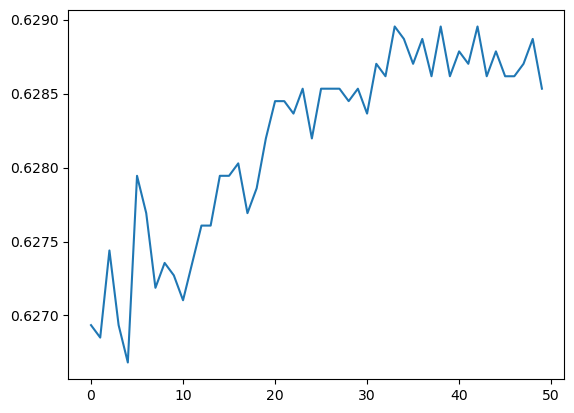

In [160]:
plt.plot(ex_X[2,:,1])

In [161]:
ex_y.shape

torch.Size([32, 1])

In [162]:
ex_y

tensor([[15],
        [35],
        [41],
        [32],
        [64],
        [10],
        [27],
        [ 2],
        [56],
        [32],
        [11],
        [39],
        [49],
        [ 7],
        [70],
        [17],
        [22],
        [39],
        [45],
        [63],
        [48],
        [ 2],
        [63],
        [39],
        [54],
        [20],
        [59],
        [72],
        [80],
        [70],
        [46],
        [34]])